In [ ]:
import importlib

import data_collector
importlib.reload(data_collector)  

import config
importlib.reload(config)  

import base_builder
importlib.reload(base_builder)

import base_update
importlib.reload(base_update)

import optimisations
importlib.reload(optimisations)

import strategies
importlib.reload(strategies)  

import performances
importlib.reload(performances) 

<module 'data_collector' from 'c:\\Users\\lunab\\Downloads\\data management\\Project\\data_collector.py'>

On importe les données de Yahoo Finance et on les enregistre en CSV

In [3]:
from data_collector import download_data, calculate_returns, save_data_to_csv

start_date="2010-01-01"
end_date="2024-12-31"

# Télécharger les données de prix
data = download_data(start_date, end_date)

# Calculer les rendements log
returns = calculate_returns(data)

# Sauvegarder les données en CSV
save_data_to_csv(data, returns)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  28 of 28 completed


Données enregistrées localement !


In [4]:
import pandas as pd
from config import assets

# Charger les rendements avec le bon séparateur
returns.index = pd.to_datetime(returns.index)  # Assurer que la colonne 'Date' est bien en datetime

# Séparer les données d'entraînement et de test

# returns
train_df = returns.loc[:'2022-12-31']
test_df = returns.loc['2023-01-01':]

# prix
data_train = data.loc[:'2022-12-31']
data_test = data.loc['2023-01-01':]

On crée la base de données

In [6]:
from base_builder import create_database
create_database()

On remplit la base de données

In [8]:
from base_update import create_session, generate_random_client_data, add_clients, add_managers, insert_products_table, insert_returns_into_db

session = create_session()

# Générer les données clients
clients_data = generate_random_client_data()
# Ajouter les clients
add_clients(session, clients_data)

managers_data = [
    {"name": "Hugo Paolini", "client_id": 1},
    {"name": "Loris Bulliard", "client_id": 2},
    {"name": "Philippe Bernard", "client_id": 3}
]

# Ajouter les managers
add_managers(session, managers_data)

# Remplir la table des produits
insert_products_table(session)

# Insérer les rendements dans la base de données (c'est ça qui prend du temps)
insert_returns_into_db(session, returns)

session.close()

Table 'products' remplie avec profils de risque !
Table 'returns' remplie !


Optimisation initiale pour obtenir les trois portefeuilles au 03/01/2023

In [ ]:
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from config import LR_assets, HY_assets, LT_assets
from optimisations import optimize_and_allocate, lowrisk_optimization, highyield_optimization, lowturnover_optimization

# Créer une session SQLAlchemy
engine = create_engine("sqlite:///Fund.db")
Session = sessionmaker(bind=engine)

# Ouvrir une session SQL
with Session() as session:
    # Stratégie Low Risk
    optimize_and_allocate(LR_assets, train_df[LR_assets], "Low risk", lowrisk_optimization, session)

    # Stratégie Low Turnover
    optimize_and_allocate(LT_assets, train_df[LT_assets], "Low turnover", lowturnover_optimization, session)
    
    # Stratégie High Yield only Equity
    optimize_and_allocate(HY_assets, train_df[HY_assets], "High yield equity only", highyield_optimization, session)

    # Commit après toutes les allocations
    session.commit()

from base_update import update_asset_price_for_specific_date, update_first_amount_held, update_weight_in_fund
update_asset_price_for_specific_date(session, data, "2023-01-03")
update_first_amount_held(session, "2023-01-03")
update_weight_in_fund()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.08036292246717175
            Iterations: 24
            Function evaluations: 264
            Gradient evaluations: 24
Volatilité annualisée du portefeuille : 0.1050
Optimisation pour la stratégie Low risk:
Actif: WMT, Poids optimisé: 0.0687
Actif: MCD, Poids optimisé: 0.2559
Actif: USMV, Poids optimisé: 0.3556
Actif: TIP, Poids optimisé: 0.0810
Actif: BNDX, Poids optimisé: 0.2388
Allocation pour la stratégie Low risk sauvegardée dans la base de données.
Nombre de transactions: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.8485159382273507
            Iterations: 5
            Function evaluations: 55
            Gradient evaluations: 5

Optimisation Low Turnover améliorée réussie:
Rendement annualisé attendu: 0.1286 (12.86%)
Ratio de Diversification: 1.1870
Indice de concentration (Herfindahl): 0.1402 (plus bas = plus diversifié)
Nombre d'actifs

c:\Users\lunab\Downloads\data management\Project\env\Lib\site-packages\scipy\optimize\_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\Users\lunab\Downloads\data management\Project\env\Lib\site-packages\scipy\optimize\_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
c:\Users\lunab\Downloads\data management\Project\env\Lib\site-packages\scipy\optimize\_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


In [ ]:
from optimisations import get_last_portfolio_allocation, normalize_allocations

# Récupérer la dernière allocation des portefeuilles low_risk (client 1), low_turnover (client 2) et high_yield (client 3)
LR_allocations = get_last_portfolio_allocation(session, client_id=1)
LT_allocations = get_last_portfolio_allocation(session, client_id=2)
HY_allocations = get_last_portfolio_allocation(session, client_id=3)

# Utilisation pour chaque catégorie d'actifs
LR_allocations, LR_weights = normalize_allocations(LR_assets, LR_allocations)
LT_allocations, LT_weights = normalize_allocations(LT_assets, LT_allocations)
HY_allocations, HY_weights = normalize_allocations(HY_assets, HY_allocations)

Elaboration des stratégies de trading pour les trois portefeuilles

In [49]:
from strategies import compute_metrics_LR , compute_metrics_LT, get_volume_data, compute_metrics_HY

df_metrics_LR = compute_metrics_LR(data, returns, LR_assets)

df_metrics_LT= compute_metrics_LT(data, returns, LT_assets)

volume_df = get_volume_data(HY_assets, start_date, end_date)
df_metrics_HY=compute_metrics_HY(data, returns, HY_assets, volume_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Prédiction grace au modèle Random Forest

Precision Score: 0.6940882414570426
Classification Report:
               precision    recall  f1-score   support

          -1       0.12      0.60      0.20        15
           0       0.98      0.82      0.90       428
           1       0.98      1.00      0.99       455

    accuracy                           0.91       898
   macro avg       0.69      0.81      0.69       898
weighted avg       0.97      0.91      0.93       898

Confusion Matrix:
 [[  9   6   0]
 [ 67 352   9]
 [  0   0 455]]
Accuracy Score: 0.9086859688195991
Vraies cibles (Target) :
Target
 1    455
 0    428
-1     15
Name: count, dtype: int64
Prédictions (Predictions) :
 1    464
 0    358
-1     76
Name: count, dtype: int64
            Target  Predictions
Date                           
2023-01-09       1            1
2023-01-09       0            0
2023-01-09       1            1
2023-01-09       1            1
2023-01-09       1            1
...            ...          ...
2024-12-23       0            0

c:\Users\lunab\Downloads\data management\Project\strategies.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Predictions'] = model.predict(predict_data[predictors])


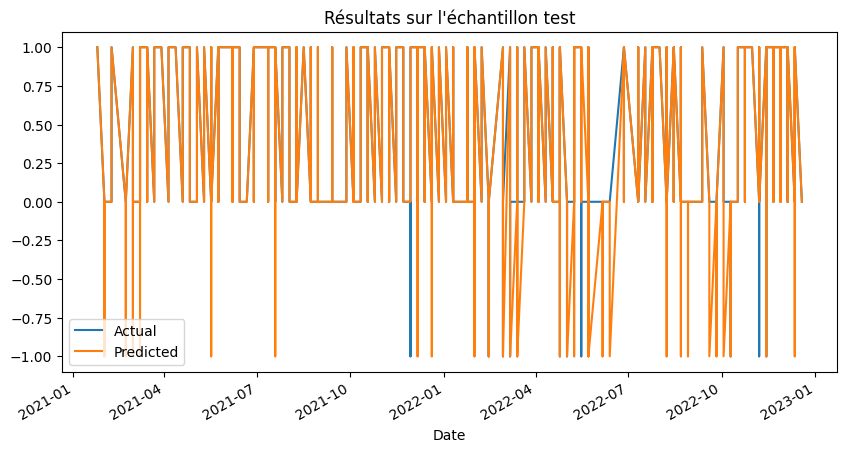

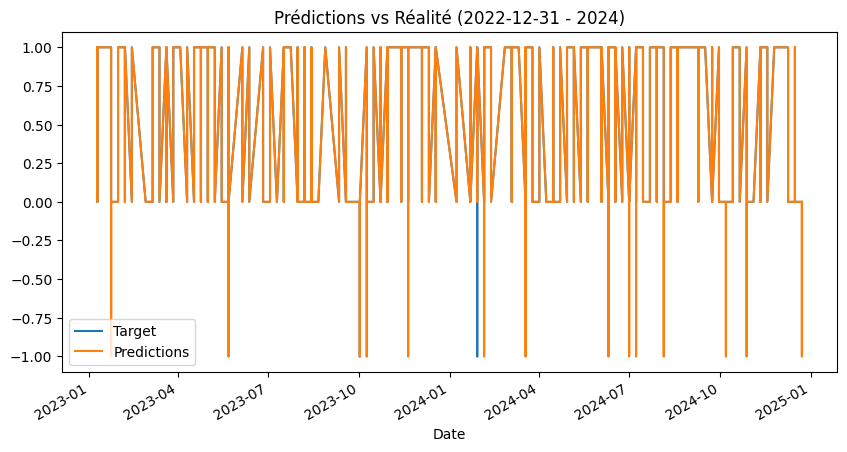

In [52]:
from strategies import train_and_predict

predictors_LR = ['Close', 'SMA_10', 'SMA_50', 'SMA_200', 'RSI_14', 
                 'Daily_Return', 'Return_5j', 'Return_10j', 
                 'Volat_5j', 'Volat_10j', 'Volat_1m', 'VOLAT_weekly']

predict_data_LR = train_and_predict(df_metrics_LR, predictors_LR, 'Target')

Precision Score: 0.8986034680949936
Classification Report:
               precision    recall  f1-score   support

          -1       0.92      0.93      0.92       151
           0       0.81      0.93      0.87       207
           1       0.97      0.63      0.76        92

    accuracy                           0.87       450
   macro avg       0.90      0.83      0.85       450
weighted avg       0.88      0.87      0.87       450

Confusion Matrix:
 [[141  10   0]
 [ 13 192   2]
 [  0  34  58]]
Accuracy Score: 0.8688888888888889
Vraies cibles (Target) :
Target
 0    207
-1    151
 1     92
Name: count, dtype: int64
Prédictions (Predictions) :
 0    236
-1    154
 1     60
Name: count, dtype: int64
            Target  Predictions
Date                           
2023-01-09       0            0
2023-01-09       0            0
2023-01-09      -1           -1
2023-01-09       0            0
2023-01-09       0            0
...            ...          ...
2024-12-02       0            1

c:\Users\lunab\Downloads\data management\Project\strategies.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Predictions'] = model.predict(predict_data[predictors])


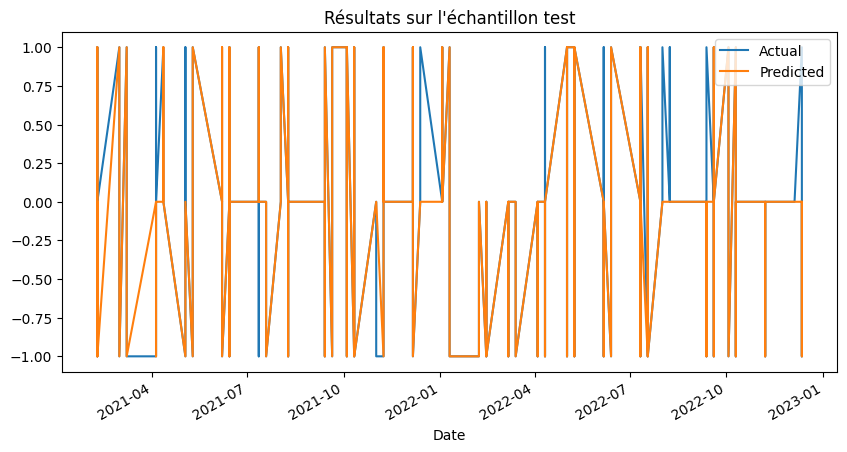

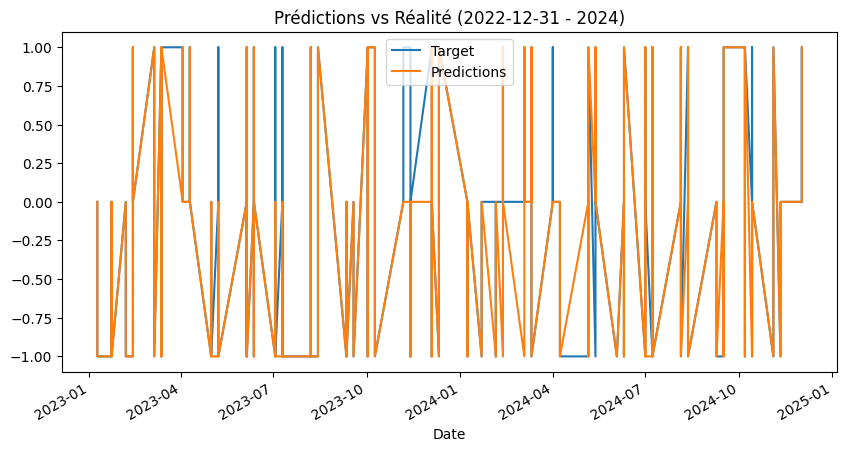

In [53]:
predictors_LT = ['Close', 'Volat_5j', 'Volat_10j', 'Volat_1m', 
                 'Return_5j', 'Return_10j', 'Daily_Return', 
                 'SMA_10', 'RSI_14', 'Sharpe', 
                 'VIX', 'Bond_Yield', 'CPI']

predict_data_LT = train_and_predict(df_metrics_LT, predictors_LT, 'Target')


Precision Score: 0.9674639554503125
Classification Report:
               precision    recall  f1-score   support

          -1       0.91      0.98      0.95       224
           0       0.99      0.95      0.97       398
           1       1.00      1.00      1.00       276

    accuracy                           0.97       898
   macro avg       0.97      0.98      0.97       898
weighted avg       0.97      0.97      0.97       898

Confusion Matrix:
 [[220   4   0]
 [ 20 378   0]
 [  1   0 275]]
Accuracy Score: 0.9721603563474388
Vraies cibles (Target) :
Target
 0    398
 1    276
-1    224
Name: count, dtype: int64
Prédictions (Predictions) :
 0    382
 1    275
-1    241
Name: count, dtype: int64
            Target  Predictions
Date                           
2023-01-09      -1           -1
2023-01-09       0            0
2023-01-09       1            1
2023-01-09       1            1
2023-01-09       0            0
...            ...          ...
2024-12-30       0            0

c:\Users\lunab\Downloads\data management\Project\strategies.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Predictions'] = model.predict(predict_data[predictors])


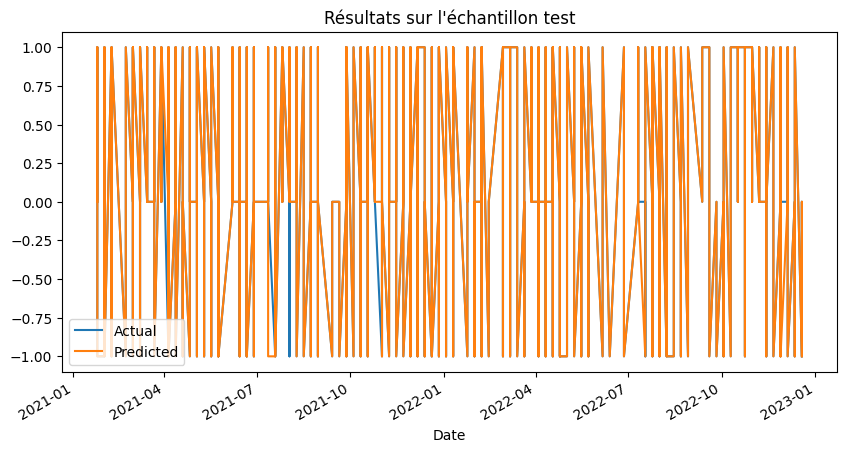

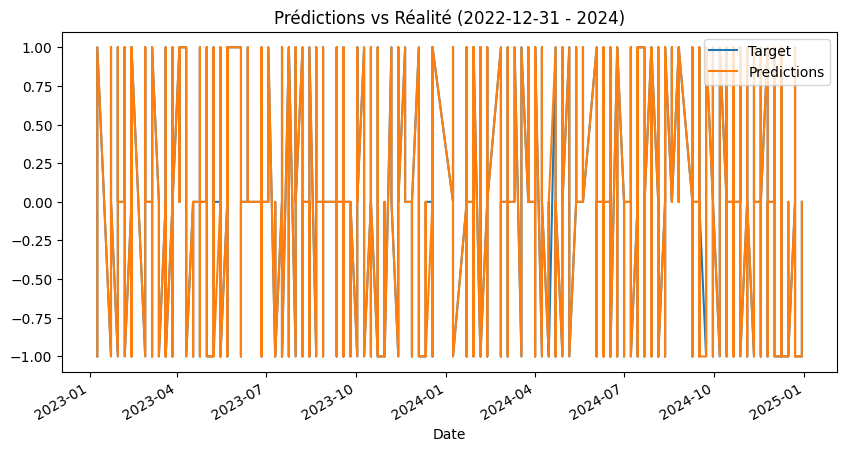

In [54]:
predictors_HY = ['Close', 'Volat_5j', 'Volat_10j', 'Return_5j', 'Return_10j', 
                 'Return_1y', 'RSI_14', 'Daily_Return', 'Weekly_Return', 
                 'SMA_50', 'SMA_200', 'Avg_Volume_50d', 'Max_Drawdown', 'Sharpe_Ratio']

predict_data_HY = train_and_predict(df_metrics_HY, predictors_HY, 'Target')

Mise à jour dans la base de données

In [55]:
from base_update import update_client_portfolio, update_weight_in_fund
# Appel de la fonction pour chaque client
update_client_portfolio(predict_data_LR, LR_allocations, LR_assets, 1, "Low risk")
update_client_portfolio(predict_data_LT, LT_allocations, LT_assets, 2, "Low turnover")
update_client_portfolio(predict_data_HY, HY_allocations, HY_assets, 3, "High yield equity only")
# On met à jour le poids de chaque manager dans le fonds
update_weight_in_fund()

Mise à jour des poids terminée.


Performances des portefeuilles

c:\Users\lunab\Downloads\data management\Project\performances.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_weights = df_weights.fillna(method='ffill')  # on utilise les memes poids jusqu'au prochain rebalancement
c:\Users\lunab\Downloads\data management\Project\performances.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_weights = df_weights.fillna(method='ffill')  # on utilise les memes poids jusqu'au prochain rebalancement
c:\Users\lunab\Downloads\data management\Project\performances.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_weights = df_weights.fillna(method='ffill')  # on utilise les memes poids jusqu'au prochain rebalancement


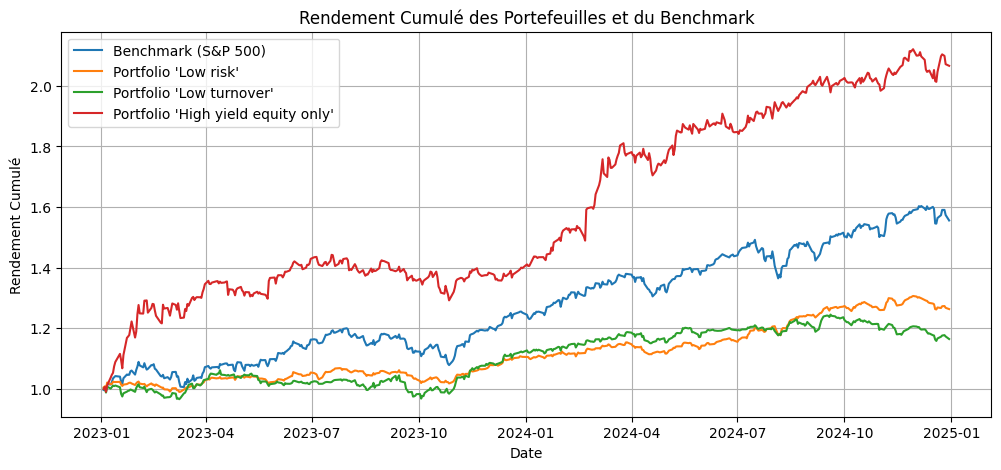

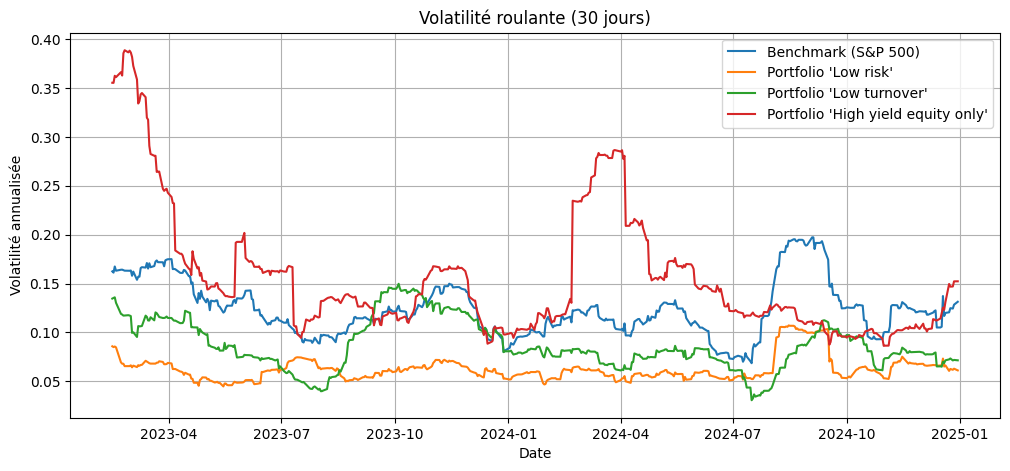

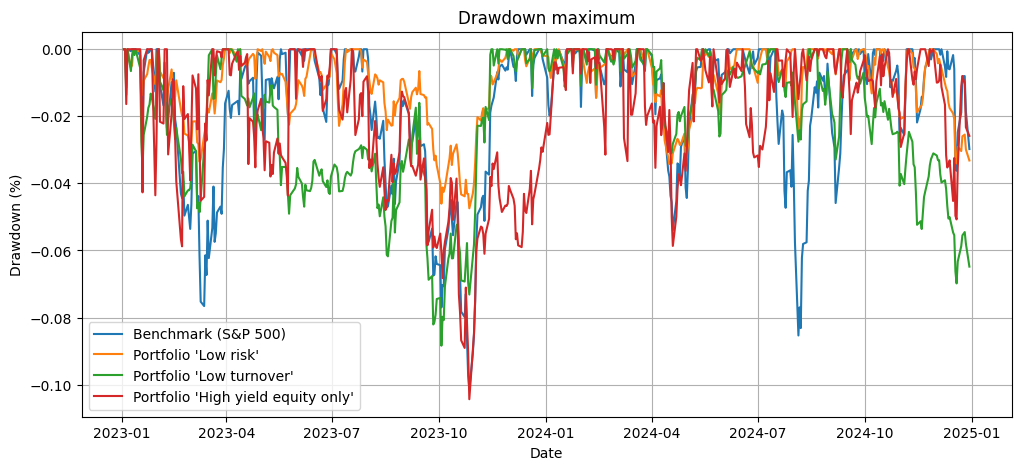

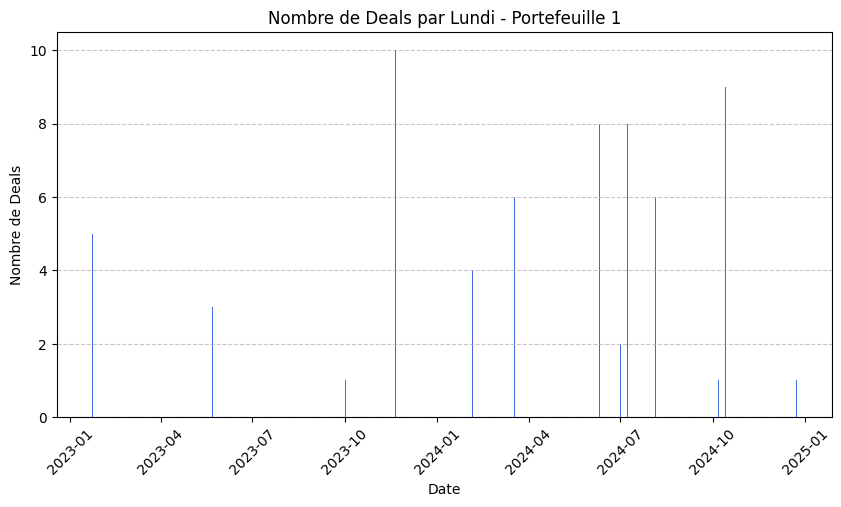

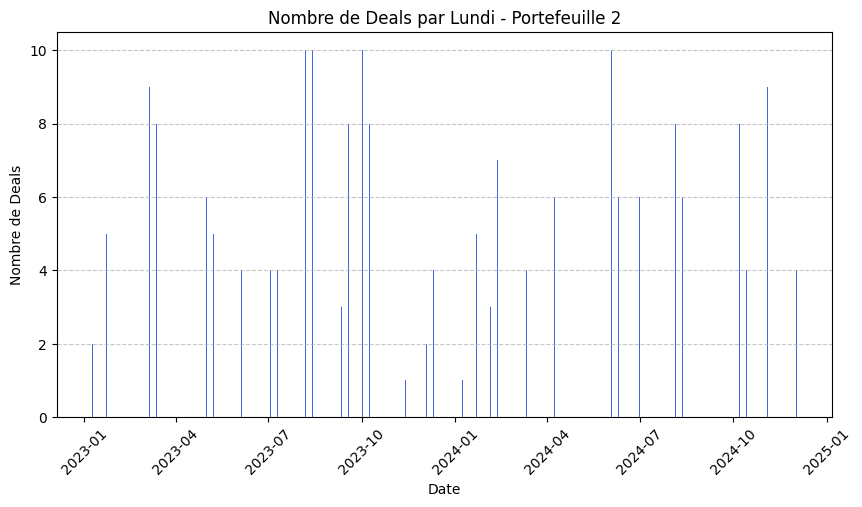

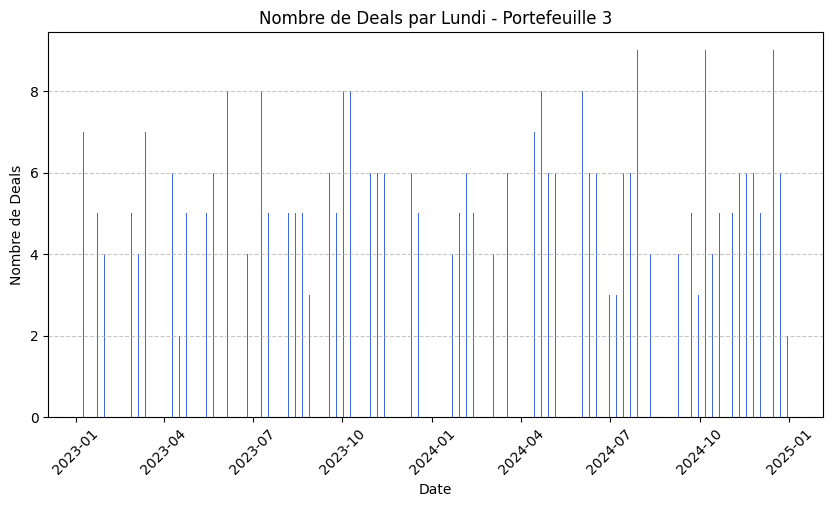

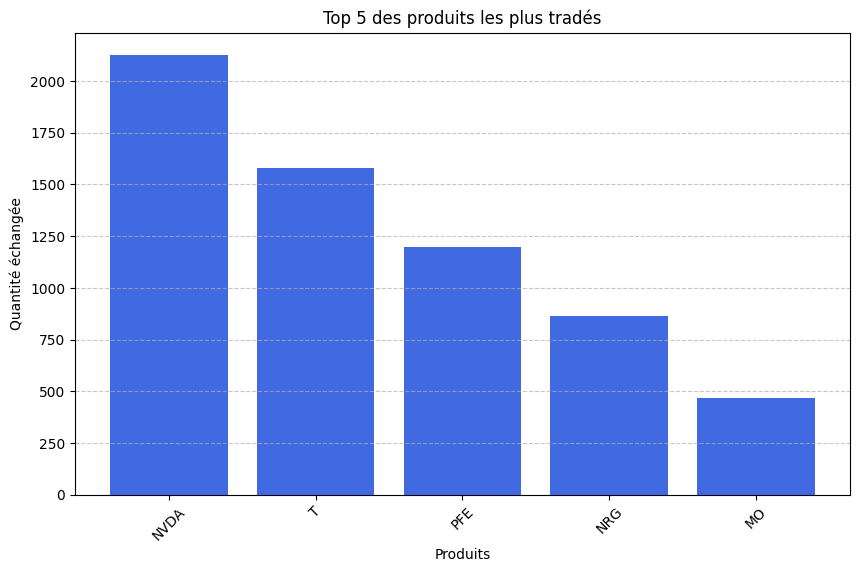

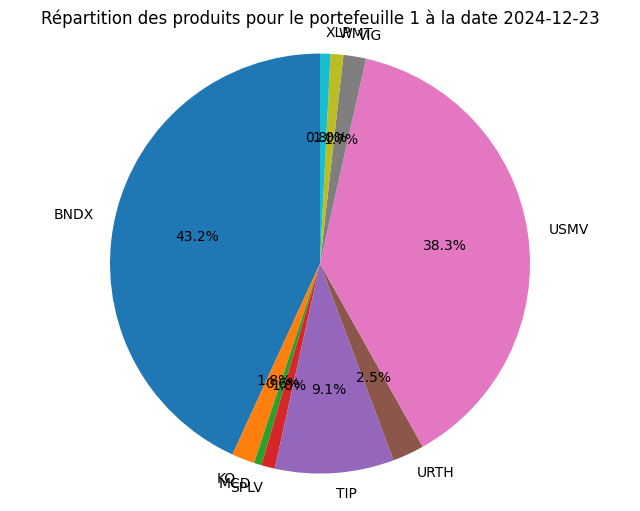

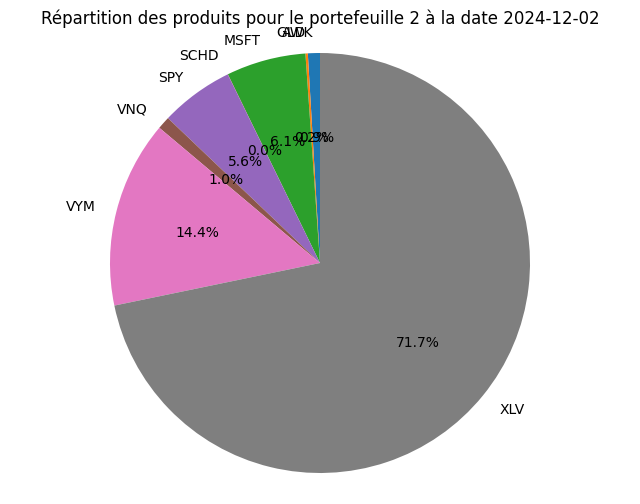

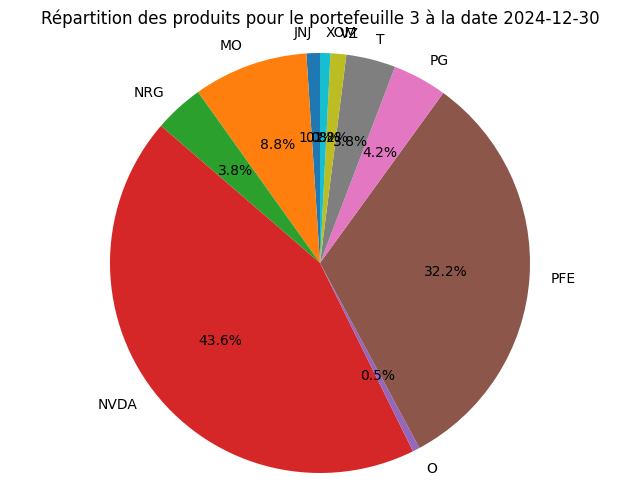

<Figure size 1200x600 with 0 Axes>

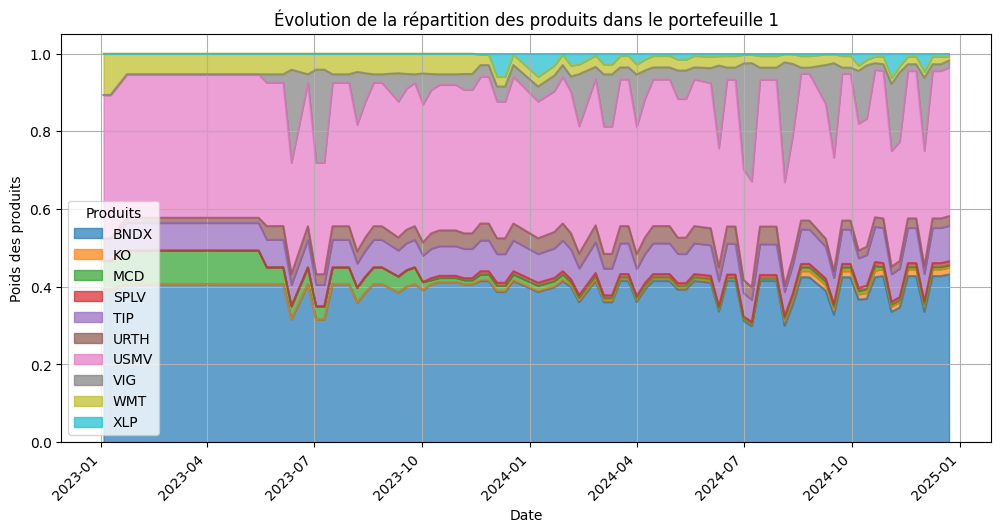

<Figure size 1200x600 with 0 Axes>

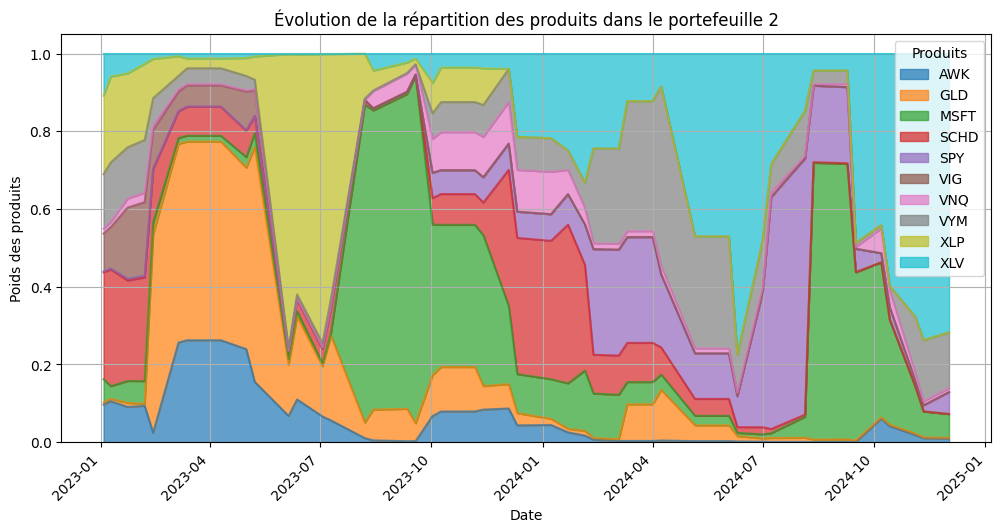

<Figure size 1200x600 with 0 Axes>

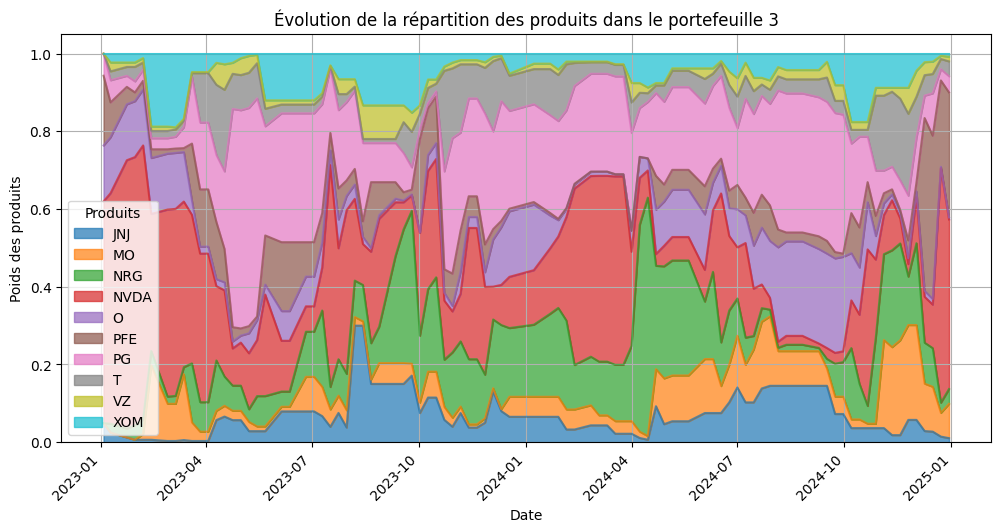

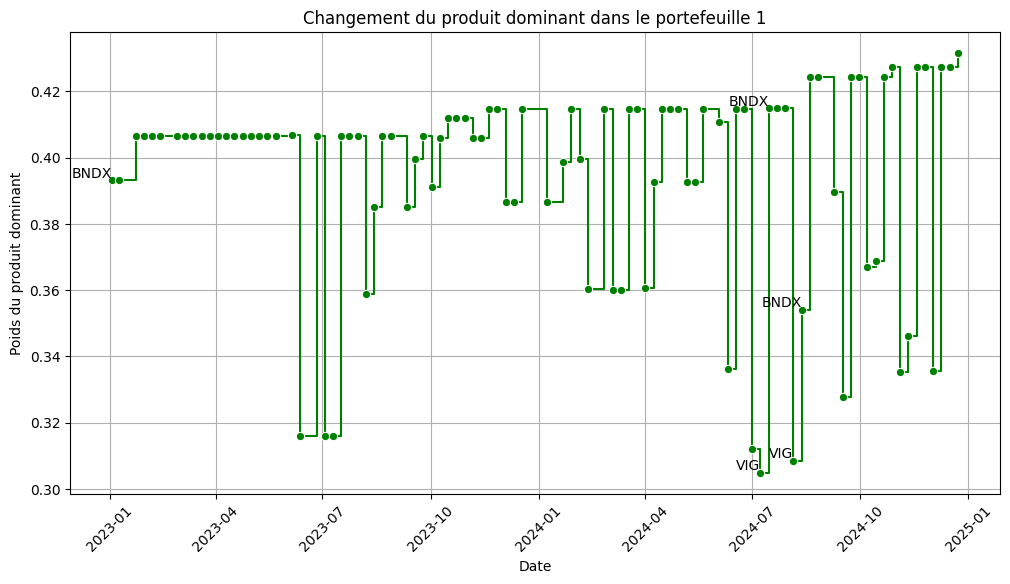

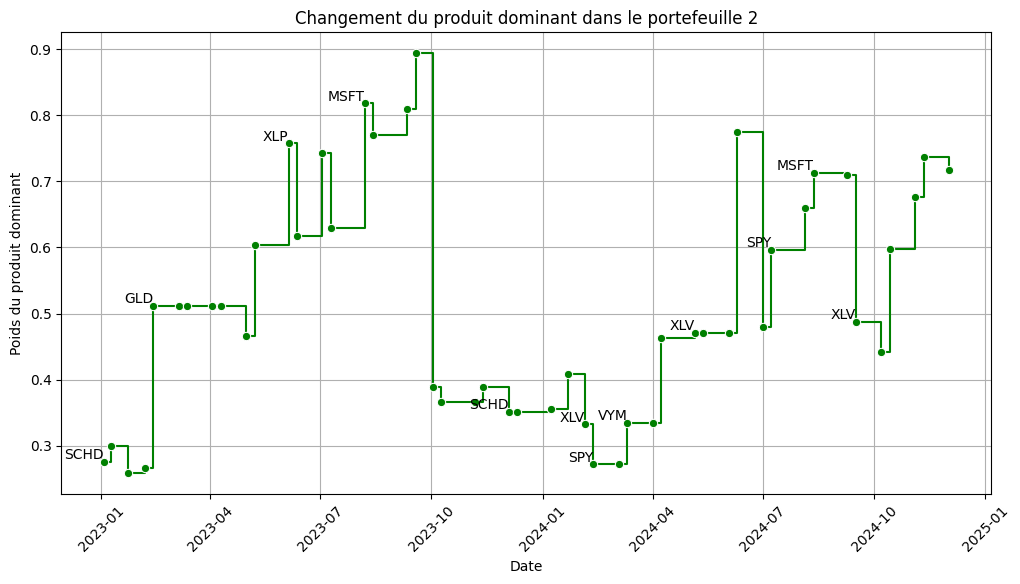

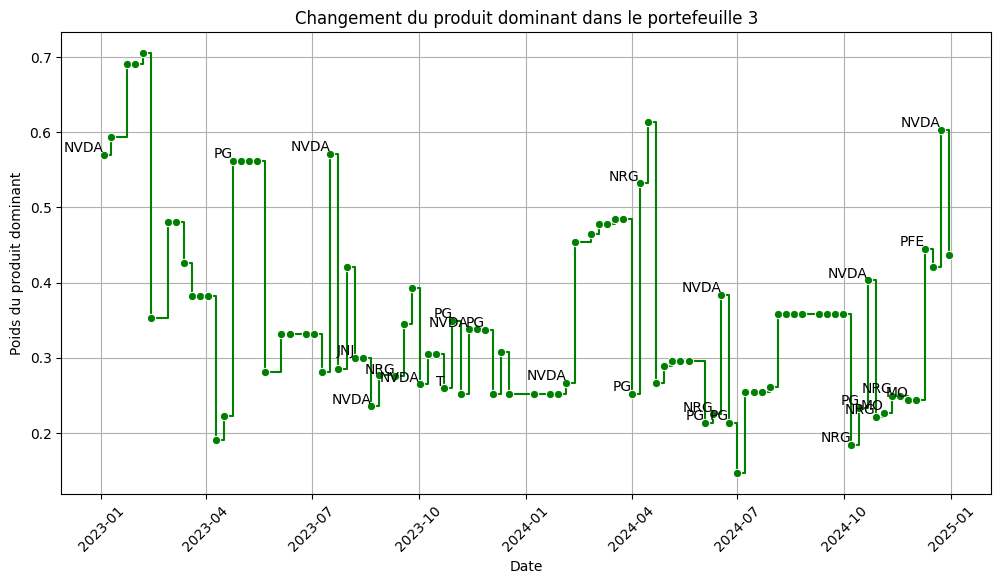

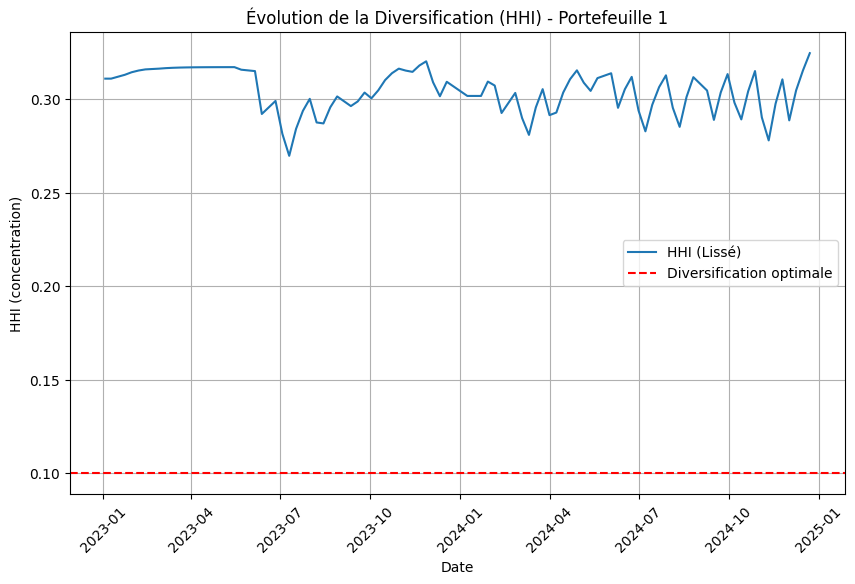

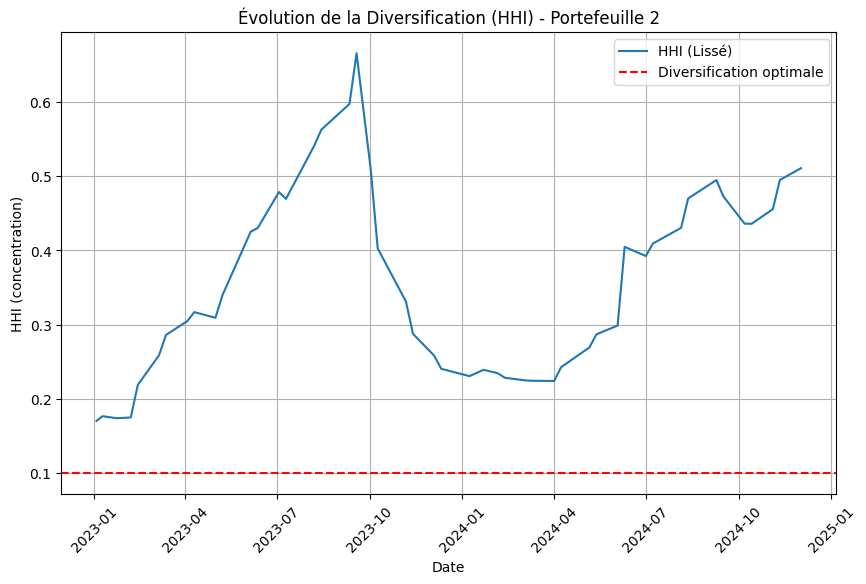

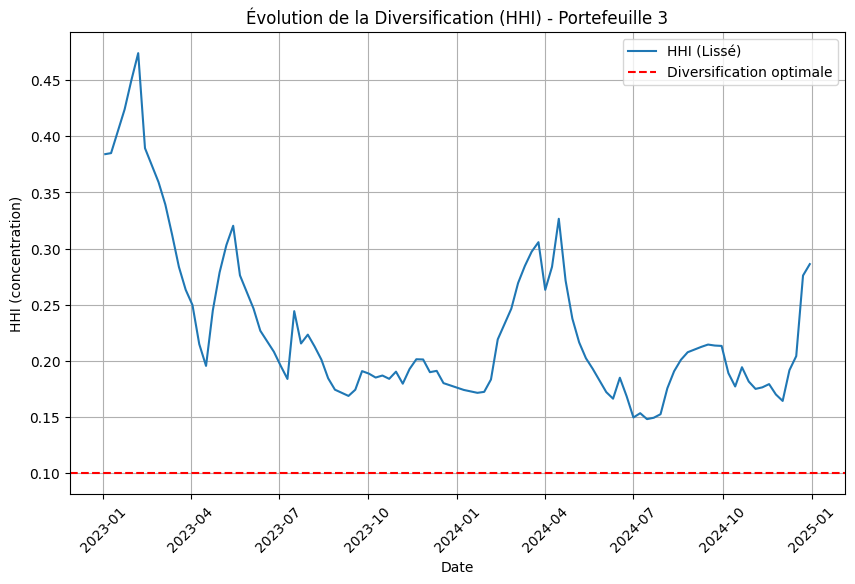

c:\Users\lunab\Downloads\data management\Project\performances.py:207: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha.append(model.params[0])
c:\Users\lunab\Downloads\data management\Project\performances.py:208: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta.append(model.params[1])
c:\Users\lunab\Downloads\data management\Project\performances.py:207: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha.append(model.params[0])

In [ ]:
import os
# Création du dossier 'reports' s'il n'existe pas
os.makedirs("reports", exist_ok=True)

from performances import generate_charts
generate_charts()

Enregistrement du rapport d'analyse de performance

In [113]:
from performances import generate_pdf_report
generate_pdf_report()

Rapport PDF généré avec succès : reports/Performance_Report.pdf
